In [1]:
# Notebook for data analysis pertaining to the perovskite radiative lifetime project

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator,AutoMinorLocator,ScalarFormatter
from matplotlib.colors import Normalize
from matplotlib import gridspec
import os

In [5]:
font_sz = 24

font = {'weight' : 'light',
       'size' : font_sz}
mpl.rcParams['font.family'] = 'Sans-Serif'
mpl.rcParams["axes.prop_cycle"]
mpl.rcParams['axes.linewidth'] = 1.0

base_dir = os.getcwd() + '/'
save_dir = base_dir + 'CsPbI3/'


In [6]:
# Define constants and global variables
global AUTOS 
global prefactor
global kB

kB = 3.167e-6
temp = 300
kBT_eV = kB * temp * 27.211 # kBT at 300K in eV

AUTOS = 2.4188843265857e-17
c = 137.03604
eps0 = (1/(4*np.pi))

prefactor = ( 3*np.pi) * eps0 * c**3 

beta = 1/(kB*temp)
cutoff = 3*kB*temp # set nstates cutoff using this.


colors = ['#44BBAE', '#AE44BB', '#BBAE44']

# Visualize Energy Levels

## Quasiparticle (electron and hole) states

The first thing to do is visualize the quasiparticle and exciton states of the perovskites. We can understand a lot from their density and distribution

In [13]:
# Plot the quasiparticle states for each size QD, for cubic, relaxed, and orthorhombic structures

# We will navigate through the file structure of the current directory, so we should store each directory
# name in a python variable
material_dirs = ['CsPbI3']

shape_dict = {'CsPbI3':['Cubic', 'Relaxed', 'Orthorhombic']}

size_dict = {'CsPbI3':['2.5', '3.1', '3.8', '4.4', '5.0', '5.7', '6.3', '6.9']}

qp = {}
xton = {}

M_qp = 64
M_xton = 256

for mat_dir in material_dirs:
    print(f"\nMaterial: {mat_dir}")
    os.chdir(base_dir + mat_dir)
    cwd = os.getcwd()
    #print(f"The current working directory is : {cwd}")
    #print(f"ls:\n{os.listdir()}")

    # We will plot all combinations of the three shapes (cubic, ortho, relax) for the eight sizes computed.
    # Their directories will be accessed by looping through these dir_lists
    
    shape_dirs = shape_dict[mat_dir]
    size_dirs = size_dict[mat_dir]
    
    # Create containers for all of the energies
    # Each list will be populated with a list containing the lowest M energies
    # for that size. The resulting list will have dimension N x M, where N is
    # the number of nanocube sizes considered.
    qp[mat_dir] = {}
    xton[mat_dir] = {}
    #qp_energies = {'cubic':[], 'ortho':[], 'relax':[]}
    #xton = {'cubic':{'energies':[],'os':[]}, 'ortho':{'energies':[],'os':[]}, 'relax':{'energies':[],'os':[]}}
    if mat_dir == 'CsPbI3': fermiEnergy = -0.19 # band edge location for CsPbI3 perovskites
    if mat_dir == 'CdSe': fermiEnergy = -0.18 # band edge location for CdSe nanocrystals
    if mat_dir == 'InP': fermiEnergy = -0.14 # band edge location for InP nanocrystals

    # Loop through the dir lists and grab the relevant energies

    for shape in shape_dirs:
        shape_dir = cwd + f"/{shape}"
        os.chdir(shape_dir)
        qp[mat_dir][shape] = {'energies':[],'os':[], 'ene_ia': []}
        xton[mat_dir][shape] = {'energies':[],'os':[], 'energies_triplet':[], 'os_triplet':[], 'energies_raw':[]}
        print(f"\nShape: {shape}")
        for size in size_dirs:
            print(f"\tSize: {size}\n")
            # Navigate into the bse directory where all the data is

            size_dir = shape_dir + f"/{size}/bse/"
            os.chdir(size_dir)
            # print(f"pwd\t{os.getcwd()}")

            # ******* QUASIPARTICLE ********
            # ******* QUASIPARTICLE ********
            # ******* QUASIPARTICLE ********

            # Now, grab the BSEeval.par file. These are all the qp eigenstates
            # used in the BSE calculation.
            all_states = np.loadtxt("BSEeval.par")

            # Separate into electrons and holes by splitting about the fermiEnergy
            # Take only the lowest M/2 states to obtain M in total
            # Then reverse the order of the states so that they decrease in energy from top to bottom (stylistic)
            elecs = all_states[all_states[:,1] > fermiEnergy][:int(M_qp/2)]
            holes = all_states[all_states[:,1] < fermiEnergy][-int(M_qp/2):]

            #print(f"The hole states\n{holes}")
            #print(f"The electron states\n{elecs}")

            # Now, we extract their energies and append them to the appropriate list
            energies = np.hstack((holes[:,1],elecs[:,1])) 
            # Place the fermiEnergy as the 0 energy line. Convert Hartree to eV
            energies = (energies - fermiEnergy)*27.211 
            qp[mat_dir][shape]['energies'].append(energies)
            
            # The OS0.dat file in the BSE directory contains the exciton energies and oscillator strengths
            # for the spin-allowed states
            OS0_dat = np.loadtxt("OS0.dat")[:,:4]
            sorted_indx = np.argsort(OS0_dat[:,3])
            OS0 = OS0_dat[sorted_indx, 2][:M_qp]
            ene_ia = OS0_dat[sorted_indx, 3][:M_qp]
            qp[mat_dir][shape]['os'].append(OS0)
            qp[mat_dir][shape]['ene_ia'].append((ene_ia - ene_ia[0])*27.211)

            # ********** EXCITON ***********
            # ********** EXCITON ***********
            # ********** EXCITON ***********

            # The OS.dat file in the BSE directory contains the exciton energies and oscillator strengths
            # for the spin-allowed states
            all_states = np.loadtxt("OS.dat")[:int(M_xton),:3]
            OS = all_states[:,1]
            energies = all_states[:,2] 
            
            if mat_dir == 'CsPbI3':
                xton[mat_dir][shape]['energies_raw'].append(energies)
                energies = (energies - energies[0])*27.211
                xton[mat_dir][shape]['os'].append(OS)
                xton[mat_dir][shape]['energies'].append(energies)
            else:
                # The OS.dat file in the ../triplet/bse directory contains the exciton energies and oscillator strengths
                # for the spin-forbidden states
                os.chdir(shape_dir + f"/{size}/triplet/bse_triplet/")
                
                all_states = np.loadtxt("OS.dat")[:int(M_xton),:3]
                
                # The oscillator strengths of formally spin forbidden states should be very small.
                # They are only nonzero through mixing with spin-allowed transitions. Measurements of 
                # the radiative rates from dark vs. bright states can be used to extract relative oscillator
                # strengths. 10.1103/PhysRevLett.103.037404
                # we can estimate that in CdSe, they are 40x smaller.
                if mat_dir == 'CdSe': os_scalef = 0.025 #1 / np.sqrt(40)
                if mat_dir == 'InP': os_scalef = 0.05 #1 / np.sqrt(40)
                
                OS_triplet_mag = OS[0] * os_scalef
                OS_triplet = OS_triplet_mag * np.ones(all_states.shape[0])
                
                energies_triplet = all_states[:,2] 
                
                if merge_triplets:
                    energies_merge = np.concatenate((energies, energies_triplet))
                    OS_merge = np.concatenate((OS, OS_triplet))
                    
                    ene_idx = np.argsort(energies_merge)
                    energies_merge = energies_merge[ene_idx]
                    
                    xton[mat_dir][shape]['energies_raw'].append(energies_merge[:M_xton])
#                   print("Energies merge pre scale: \n", energies_merge, '\n')

                    energies_merge = (energies_merge - energies_merge[0])*27.211
                    OS_merge = OS_merge[ene_idx]
                    
                    xton[mat_dir][shape]['energies'].append(energies_merge[:M_xton])
                    xton[mat_dir][shape]['os'].append(OS_merge[:M_xton])
                    #print("Energies post:\n ", xton[mat_dir][shape]['energies_raw'], '\n')
                    #print("OS post: \n", xton[mat_dir][shape]['os'], '\n')
                else:
                    xton[mat_dir][shape]['os'].append(OS)
                    xton[mat_dir][shape]['energies_raw'].append(energies)
                    xton[mat_dir][shape]['energies'].append((energies-energies[0])*27.211)
                    
                    xton[mat_dir][shape]['os_triplet'].append(OS_triplet)
                    xton[mat_dir][shape]['energies_triplet'].append(energies)
                
            
            os.chdir(shape_dir)
            
        
        qp[mat_dir][shape]['energies'] = np.array(qp[mat_dir][shape]['energies'])
        qp[mat_dir][shape]['os'] = np.array(qp[mat_dir][shape]['os'])
        qp[mat_dir][shape]['ene_ia'] = np.array(qp[mat_dir][shape]['ene_ia'])
        
        xton[mat_dir][shape]['os'] = np.array(xton[mat_dir][shape]['os'])
        xton[mat_dir][shape]['energies'] = np.array(xton[mat_dir][shape]['energies'])
        xton[mat_dir][shape]['os_triplet'] = np.array(xton[mat_dir][shape]['os_triplet'])
        xton[mat_dir][shape]['energies_triplet'] = np.array(xton[mat_dir][shape]['energies_triplet'])
        xton[mat_dir][shape]['energies_raw'] = np.array(xton[mat_dir][shape]['energies_raw'])
        
    

os.chdir(base_dir)


Material: CsPbI3

Shape: Cubic
	Size: 2.5

	Size: 3.1

	Size: 3.8

	Size: 4.4

	Size: 5.0

	Size: 5.7

	Size: 6.3

	Size: 6.9


Shape: Relaxed
	Size: 2.5

	Size: 3.1

	Size: 3.8

	Size: 4.4

	Size: 5.0

	Size: 5.7

	Size: 6.3

	Size: 6.9


Shape: Orthorhombic
	Size: 2.5

	Size: 3.1

	Size: 3.8

	Size: 4.4

	Size: 5.0

	Size: 5.7

	Size: 6.3

	Size: 6.9



# Visualize quasiparticle energy levels

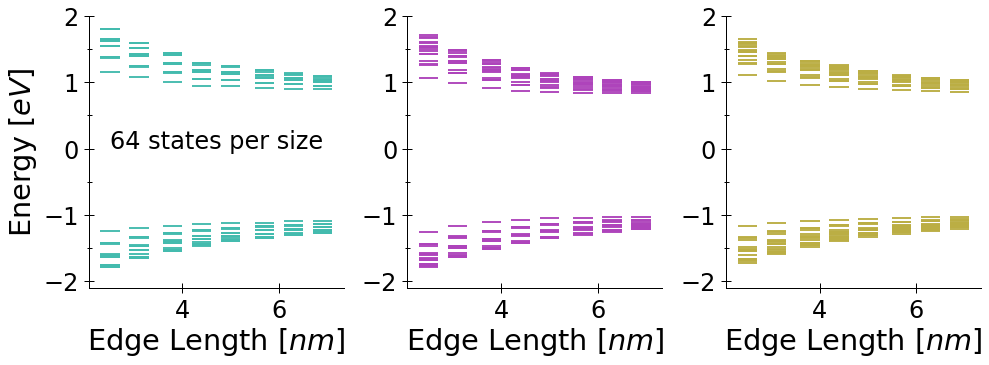

In [14]:
# We can now plot each of these energy level diagrams.
colors = ['#44BBAE', '#AE44BB', '#BBAE44']
for mat_dir in material_dirs:
    os.chdir(base_dir + mat_dir)
    n_shapes = len(shape_dict[mat_dir])
    # Create a set of axes
    if n_shapes > 1:
        fig, ax = plt.subplots(1,len(shape_dict[mat_dir]))
        # Configure the axes to plot energy level diagrams
        for i in range(len(ax)):
            ax[i].yaxis.set_minor_locator(AutoMinorLocator(2))
            ax[i].tick_params(top=False, bottom=True, left=True, right=False)
            #ax.locator_params(axis='both',nbins=5)
            ax[i].tick_params(axis='both',which='major', direction='inout',length=10,width=1.0,color='black',pad=5,labelsize=font_sz,labelcolor='black',labelrotation=0)
            ax[i].tick_params(axis='y',which='minor', direction='inout',length=5,width=1.0,color='black',labelsize=font_sz,labelcolor='black',labelrotation=0)
            ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False); #ax[i].spines['bottom'].set_visible(False)
            ax[i].set_ylim(-2.1, 2.)
            ax[i].set_xlabel(r'Edge Length $[nm]$', fontsize='large')
        ax[0].set_ylabel(r'Energy $[eV]$', fontsize='large')
        plt.subplots_adjust(wspace=0.25)
    else:
        fig, ax = plt.subplots()
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.tick_params(top=False, bottom=True, left=True, right=False)
        #ax.locator_params(axis='both',nbins=5)
        ax.tick_params(axis='both',which='major', direction='inout',length=10,width=1.0,color='black',pad=5,labelsize=font_sz,labelcolor='black',labelrotation=0)
        ax.tick_params(axis='y',which='minor', direction='inout',length=5,width=1.0,color='black',labelsize=font_sz,labelcolor='black',labelrotation=0)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); #ax[i].spines['bottom'].set_visible(False)
        ax.set_ylim(-2.1, 2.)
        ax.set_xlabel(r'Diameter $[nm]$', fontsize='large')
        ax.set_ylabel(r'Energy $[eV]$', fontsize='large')
    
    fig.set_size_inches(n_shapes*5.33,5)
    fig.patch.set_facecolor('w')
    edge_lens = np.array(size_dict[mat_dir], dtype=np.float64)

    sizes = np.repeat(edge_lens,M_qp).reshape(len(edge_lens),-1)
    
    l_wid = round((edge_lens[1] - edge_lens[0])/3, 2) # split the space between sizes into thirds; each bar takes 2/3 width
    
    if n_shapes > 1:
        for i, shape in enumerate(shape_dict[mat_dir]):
            #ax[i].set_title(shape + ' ' + mat_dir, fontsize=font_sz)
            for j in range(len(size_dict[mat_dir])):
                ax[i].hlines(xmin=sizes[j]-l_wid,xmax=sizes[j]+l_wid, y=qp[mat_dir][shape]['energies'][j], color=colors[i])

        ax[0].text(edge_lens[0],0,f"{M_qp} states per size", fontsize=font_sz)
    else:
        for i, shape in enumerate(shape_dict[mat_dir]):
            #ax.set_title(shape + ' ' + mat_dir, fontsize=font_sz)
            for j in range(len(size_dict[mat_dir])):
                ax.hlines(xmin=sizes[j]-l_wid,xmax=sizes[j]+l_wid, y=qp[mat_dir][shape][j], color=colors[i])
            ax.text(edge_lens[0],0,f"{M_qp} states per size", fontsize=font_sz)
    #plt.ylim(0.85,1.0)
    #plt.xlim(4.9,6.0)
    plt.rcParams.update({'font.size': 24})
    plt.savefig(f"{mat_dir}_qp_states_allsizes.pdf", dpi=300, format='pdf', bbox_inches = 'tight', pad_inches = 0.1)

os.chdir(base_dir)

# Plot uncorrelated exciton level diagram

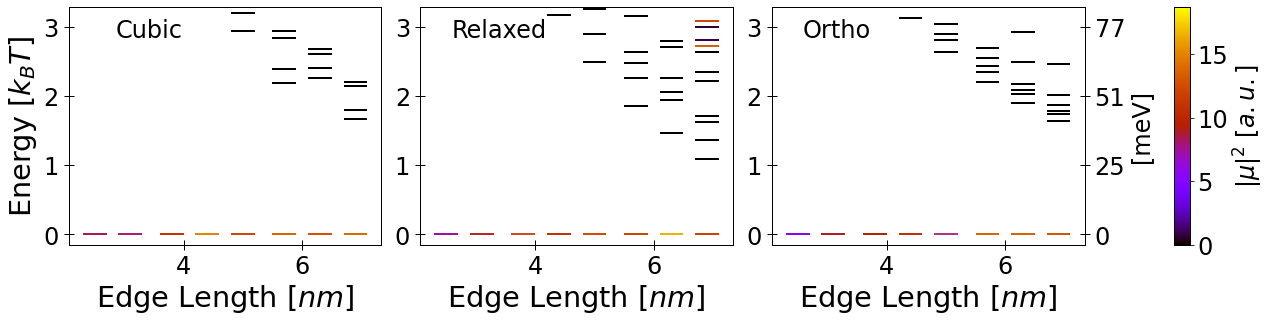

In [15]:
# We will also visualize the exciton states, highlighting which are dark and which are bright
# Plot each of these energy level diagrams.
kB = 3.167e-6
temp = 300
kBT_eV = kB * temp * 27.211 # kBT at 300K in eV
text_offsets = [0.15, 0.1, 0.1]
shape_names = ["Cubic", "Relaxed", "Ortho"]

for mat_dir in material_dirs:
    os.chdir(base_dir + mat_dir)
    # Create a 1,4 set of axes
    n_shapes = len(shape_dict[mat_dir])
    wd_ratios = [1]*n_shapes + [0.04]  + [0.05]
    gs = gridspec.GridSpec(1, n_shapes+2, width_ratios=wd_ratios)

    fig, ax = plt.subplots(1,n_shapes + 2, figsize=(n_shapes*5.73+1, 5), gridspec_kw={'width_ratios': wd_ratios})
    ax[-2].set_visible(False)
    fig.patch.set_facecolor('w')
    plt.rcParams.update({'font.size': 24})
    # create a numpy array of the edge lengths for the size series of the current material
    edge_lens = np.array(size_dict[mat_dir], dtype=np.float64)

    # Configure the axes to plot energy level diagrams
    for i in range(len(ax)-2):
        #ax[i].yaxis.set_minor_locator(AutoMinorLocator(2))
        ax[i].tick_params(top=False, bottom=True, left=True, right=False)
        ax[i].locator_params(axis='x',nbins=5)
        ax[i].tick_params(axis='both',which='major', direction='inout',length=10,width=1.0,color='black',pad=5,labelsize=font_sz,labelcolor='black',labelrotation=0)
        #ax[i].tick_params(axis='y',which='minor', direction='inout',length=5,width=1.0,color='black',labelsize=font_sz,labelcolor='black',labelrotation=0)
        ax[i].spines['top'].set_visible(True); ax[i].spines['right'].set_visible(True); #ax[i].spines['bottom'].set_visible(False)
        ax[i].set_ylim(-0.15,3.3)
        #ax[i].set_xlim(1.2,6.)
        if mat_dir == 'CsPbI3': ax[i].set_xlabel(r'Edge Length $[nm]$', fontsize='large')
        else: ax[i].set_xlabel(r'Diameter $[nm]$', fontsize='large')
    ax[0].set_ylabel(r'Energy $[k_BT]$', fontsize='large')
    ax[-1].set_xticks([]) 
    ax[-1].set_yticks([]) 
    ax_eV = ax[-3].twinx()
    ax_eV.set_ylim(-0.15,3.3)
    ax_eV.set_yticks([0,1,2,3], labels=(1000*np.array([0,1,2,3])*kBT_eV).astype(np.int16), fontsize=font_sz, color='black' ) # set the ticks in eV
    ax_eV.set_ylabel('[meV]', fontsize=font_sz)
    ax_eV.tick_params(axis='y',which='major', direction='inout',length=10,width=1.0,color='black',pad=5,labelsize=font_sz,labelcolor='black',labelrotation=0)


    sizes = np.repeat(edge_lens,int(M_qp)).reshape(len(size_dict[mat_dir]),-1)
    l_wid = round((edge_lens[1] - edge_lens[0])/3, 2) 
    
    for i, shape in enumerate(shape_dict[mat_dir]):
        output = np.concatenate((edge_lens.reshape(-1,1), (qp[mat_dir][shape]['ene_ia']) ), axis=1)
        np.savetxt(f"{save_dir}CsPbI3_qp_E_{shape}.dat", output.T, fmt="%-3.5f")
        
        output = np.concatenate((edge_lens.reshape(-1,1), (qp[mat_dir][shape]['os']**2) ), axis=1)
        np.savetxt(f"{save_dir}CsPbI3_qp_mu2_{shape}.dat", output.T, fmt="%-3.5f")
        
        ax[i].text(text_offsets[i], 0.95, shape_names[i], transform=ax[i].transAxes,
                    verticalalignment='top', horizontalalignment='left')
        
        values = qp[mat_dir][shape]['os'].flatten()**2
        for j in range(len(size_dict[mat_dir])):
            # This is where we plot all the energy levels for a certain size along with its brightness
            # We define the color for each line based on its oscillator strength
            color_values = qp[mat_dir][shape]['os'][j]**2
            # We create a colormap for the range of values
            cmap = plt.get_cmap('gnuplot')
            # Normalize the color values to the range [0, 1]
            norm = Normalize(vmin=values.min(), vmax=values.max()+2)

            ax[i].hlines(xmin=sizes[j]-l_wid,xmax=sizes[j]+l_wid, y=qp[mat_dir][shape]['ene_ia'][j]/kBT_eV, linewidth=1.5,color=cmap(norm(color_values)))
        
    
    # Add a colorbar to the right of the main plot
    cax = fig.add_subplot(gs[0, -1])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # To satisfy the ScalarMappable
    cbar = plt.colorbar(sm, label=r'$|\mu|^2\ [a.u.]$', cax=cax, orientation='vertical')

    cbar.ax.xaxis.set_ticks([])
    cbar.ax.xaxis.set_visible(False)
    #cbar.ax.yaxis.set_ticks([])
    #cbar.set_label(r'$|\mu|^2$ (a.u.)', fontsize=font_sz)
    
    # Adjust layout to prevent clipping of colorbars
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.20)
    plt.savefig(f"{mat_dir}_qp_states_allsizes_gnuplot.pdf", dpi=300, format='pdf', bbox_inches = 'tight', pad_inches = 0.1)
    plt.show()
    
os.chdir(base_dir)


## Plot correlated exciton energy level diagram

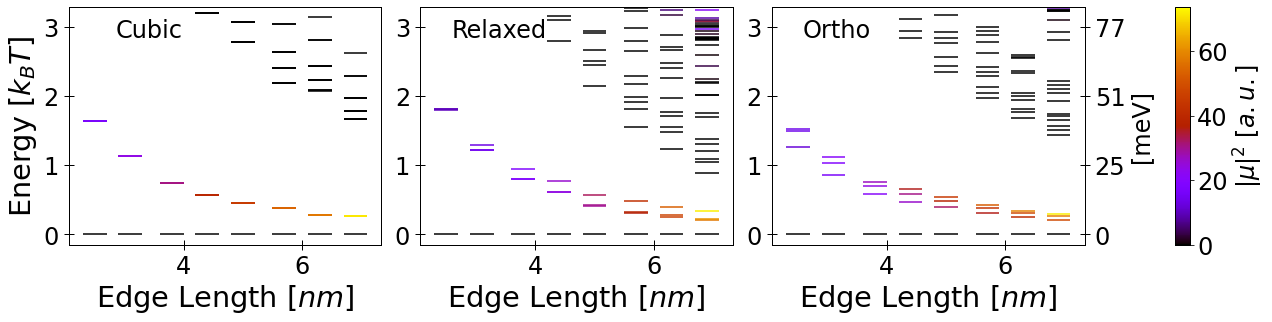

In [16]:
# We will also visualize the exciton states, highlighting which are dark and which are bright
# Plot each of these energy level diagrams.
kB = 3.167e-6
temp = 300
kBT_eV = kB * temp * 27.211 # kBT at 300K in eV
text_offsets = [0.15, 0.1, 0.1]
shape_names = ["Cubic", "Relaxed", "Ortho"]

for mat_dir in material_dirs:
    os.chdir(base_dir + mat_dir)
    # Create a 1,4 set of axes
    n_shapes = len(shape_dict[mat_dir])
    wd_ratios = [1]*n_shapes + [0.04]  + [0.05]
    gs = gridspec.GridSpec(1, n_shapes+2, width_ratios=wd_ratios)

    fig, ax = plt.subplots(1,n_shapes + 2, figsize=(n_shapes*5.73+1, 5), gridspec_kw={'width_ratios': wd_ratios})
    ax[-2].set_visible(False)
    fig.patch.set_facecolor('w')
    plt.rcParams.update({'font.size': 24})
    # create a numpy array of the edge lengths for the size series of the current material
    edge_lens = np.array(size_dict[mat_dir], dtype=np.float64)

    # Configure the axes to plot energy level diagrams
    for i in range(len(ax)-2):
        #ax[i].yaxis.set_minor_locator(AutoMinorLocator(2))
        ax[i].tick_params(top=False, bottom=True, left=True, right=False)
        ax[i].locator_params(axis='x',nbins=5)
        ax[i].tick_params(axis='both',which='major', direction='inout',length=10,width=1.0,color='black',pad=5,labelsize=font_sz,labelcolor='black',labelrotation=0)
        #ax[i].tick_params(axis='y',which='minor', direction='inout',length=5,width=1.0,color='black',labelsize=font_sz,labelcolor='black',labelrotation=0)
        ax[i].spines['top'].set_visible(True); ax[i].spines['right'].set_visible(True); #ax[i].spines['bottom'].set_visible(False)
        ax[i].set_ylim(-0.15,3.3)
        #ax[i].set_xlim(1.2,6.)
        if mat_dir == 'CsPbI3': ax[i].set_xlabel(r'Edge Length $[nm]$', fontsize='large')
        else: ax[i].set_xlabel(r'Diameter $[nm]$', fontsize='large')
    ax[0].set_ylabel(r'Energy $[k_BT]$', fontsize='large')
    ax[-1].set_xticks([]) 
    ax[-1].set_yticks([]) 
    ax_eV = ax[-3].twinx()
    ax_eV.set_ylim(-0.15,3.3)
    ax_eV.set_yticks([0,1,2,3], labels=(1000*np.array([0,1,2,3])*kBT_eV).astype(np.int16), fontsize=font_sz, color='black' ) # set the ticks in eV
    ax_eV.set_ylabel('[meV]', fontsize=font_sz)
    ax_eV.tick_params(axis='y',which='major', direction='inout',length=10,width=1.0,color='black',pad=5,labelsize=font_sz,labelcolor='black',labelrotation=0)


    sizes = np.repeat(edge_lens,int(M_xton)).reshape(len(size_dict[mat_dir]),-1)
    l_wid = round((edge_lens[1] - edge_lens[0])/3, 2) 
    
    for i, shape in enumerate(shape_dict[mat_dir]):
        #ax[i].set_title(shape + ' ' + mat_dir, fontsize=font_sz)
        values = xton[mat_dir][shape]['os'].flatten()**2
        for j in range(len(size_dict[mat_dir])):
            # This is where we plot all the energy levels for a certain size along with its brightness
            # We define the color for each line based on its oscillator strength
            color_values = xton[mat_dir][shape]['os'][j]**2
            # We create a colormap for the range of values
            cmap = plt.get_cmap('gnuplot')
            # Normalize the color values to the range [0, 1]
            norm = Normalize(vmin=values.min(), vmax=values.max()+2)

            ax[i].hlines(xmin=sizes[j]-l_wid,xmax=sizes[j]+l_wid, y=xton[mat_dir][shape]['energies'][j]/kBT_eV, linewidth=1.5,color=cmap(norm(color_values)))
        ax[i].text(text_offsets[i], 0.95, shape_names[i], transform=ax[i].transAxes,
                    verticalalignment='top', horizontalalignment='left')

    # Create a gridspec for the colorbar
    #gs = gridspec.GridSpec(2, 2, width_ratios=[1, 0.05], height_ratios=[100, .1])
#     ax[0].text(0.34, 0.38, "Bright-dim gap", transform=ax[0].transAxes,
#                     verticalalignment='top', horizontalalignment='left')

    # Add a colorbar to the right of the main plot
    cax = fig.add_subplot(gs[0, -1])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # To satisfy the ScalarMappable
    cbar = plt.colorbar(sm, label=r'$|\mu|^2\ [a.u.]$', cax=cax, orientation='vertical')

    cbar.ax.xaxis.set_ticks([])
    cbar.ax.xaxis.set_visible(False)
    #cbar.ax.yaxis.set_ticks([])
    #cbar.set_label(r'$|\mu|^2$ (a.u.)', fontsize=font_sz)
    
    # Adjust layout to prevent clipping of colorbars
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.20)
    plt.savefig(f"{mat_dir}_xton_states_allsizes_gnuplot.pdf", dpi=800, format='pdf', bbox_inches = 'tight', pad_inches = 0.1)
    plt.show()
    
os.chdir(base_dir)

# Compute Radiative Lifetimes

In [17]:
def calc_radiative(w, mu2, boltz_factors, Q):
    
    # First we compute all the rates in ns^-1 
    
    rates = (w**3 * mu2) / prefactor / AUTOS / 1e9
    
    zero_mask = (rates != 0).astype(bool)
    rates = rates[zero_mask]
    boltz_factors = boltz_factors[zero_mask]
    
    # Compute the thermal average rates and lifetimes
    
    avg_rate = (1/Q) * np.sum(boltz_factors * rates)  
    avg_lifetime = (1/avg_rate) 

    return avg_rate, avg_lifetime


In [18]:
temp_list = [300]#, 250]#, 200, 100, 70]

os_files = ["OS0.dat", "OS.dat"]

print_flag = 1

if print_flag:
    print('\nRunning radiative.py...')

# Calculate the radiative lifetimes of each nanocrystal configuration

# Make containers for the rates and lifetimes of each of the materials
rates = {}
lifetimes = {}
boltz_prob_dict = {}
mu2_dict = {}
ene_dict = {}

n_qp = 256
n_xton = 2000

for temp in temp_list:
    print(f"\nTemperature: {temp}\n\n")
    rates[temp] = {}
    lifetimes[temp] = {}
    boltz_prob_dict[temp] = {}
    mu2_dict[temp] = {}
    ene_dict[temp] = {}

    
    kBT_eV = (kB * temp) * 27.211
    print("kBT_eV = ", kBT_eV)
    for mat_dir in material_dirs:
        os.chdir(base_dir + mat_dir)
        cwd = os.getcwd()
        rates[temp][mat_dir] = {}
        lifetimes[temp][mat_dir] = {}
        boltz_prob_dict[temp][mat_dir] = {}
        mu2_dict[temp][mat_dir] = {}
        ene_dict[temp][mat_dir] = {}

        for shape in shape_dict[mat_dir]:
            print(f"\n{shape}")
            shape_dir = cwd + f"/{shape}"
            os.chdir(shape_dir)

            rates[temp][mat_dir][shape] = {'xton':[], 'qp':[]}
            lifetimes[temp][mat_dir][shape] = {'xton':[], 'qp':[]}
            boltz_prob_dict[temp][mat_dir][shape] = {'xton':[], 'qp':[]}
            mu2_dict[temp][mat_dir][shape] = {'xton':[], 'qp':[]}
            ene_dict[temp][mat_dir][shape] = {'xton':[], 'qp':[]}

            for i, size in enumerate(size_dict[mat_dir]):
                print(f"\t{size}")
                # Navigate into the bse directory where all the data is

                size_dir = shape_dir + f"/{size}/bse/"
                os.chdir(size_dir)

                for eh_idx in range(len(os_files)):
                    
                    if eh_idx == 0:
                        state_type = 'qp'
                        if shape == 'wurtzite': 
                            print("Skipping one row in wurtzite")
                            skip_row = 1
                    if eh_idx == 1:
                        state_type = 'xton'
                        
                    if print_flag:
                        print('\n'+ '*'*43)
                        print(f"Calculating {state_type} radiative rates")
                        print('*'*43 + '\n')
                    
                    
                    # Get the dipole moment values for each state and their corresponding energy
                    
                    os_file = np.loadtxt(os_files[eh_idx], dtype=np.float64, skiprows=skip_row)
                    
                    ene = os_file[:,3-eh_idx]
                    os2 = os_file[:,2-eh_idx]**2 # Grab sqrt(mu^2) and square it
                    
                    # sort the OS0 file
                    if state_type == 'qp':
                        sorted_indx = np.argsort(ene)
                        ene = ene[sorted_indx]
                        os2 = os2[sorted_indx]
                        ene_cut = ene[:n_qp]
                        os2_cut = os2[:n_qp]
                    elif state_type == 'xton':
                        ene_cut = ene[:n_xton]
                        os2_cut = os2[:n_xton]
                        
                    #print(f"\nENE_CUT: {ene_cut}")
                    boltz_factors = np.exp(- ((ene_cut - ene_cut[0])*27.211) / kBT_eV)
                    Q = np.sum(boltz_factors)
                    rate, lifetime = calc_radiative(ene_cut, os2_cut, boltz_factors, Q)

                    rates[temp][mat_dir][shape][state_type].append(rate)
                    lifetimes[temp][mat_dir][shape][state_type].append(lifetime)
                    mu2_dict[temp][mat_dir][shape][state_type].append(os2[:n_xton])
                    ene_dict[temp][mat_dir][shape][state_type].append(ene[:n_xton])
                    boltz_prob_dict[temp][mat_dir][shape][state_type].append(boltz_factors[:n_xton]/Q)
                    
                    
                    if print_flag:
                        print('Radiative rate = {:.4f} [ns^-1]'.format(rate) + '\nRadiative lifetime = {:.4f} [ns]\n'.format(lifetime) )
                        
                
            # Convert lists to numpy arrays for printing
            edge_lens = np.array(size_dict[mat_dir], dtype=np.float64)

            for eh_typ in ['qp', 'xton']:
                rates[temp][mat_dir][shape][eh_typ] = np.array(rates[temp][mat_dir][shape][eh_typ])
                lifetimes[temp][mat_dir][shape][eh_typ] = np.array(lifetimes[temp][mat_dir][shape][eh_typ])
            
#                 if eh_typ == 'xton':
#                     print(f"boltz shape {boltz_prob_dict[temp][mat_dir][shape][eh_typ].shape}")
                boltz_prob_dict[temp][mat_dir][shape][eh_typ] = np.array(boltz_prob_dict[temp][mat_dir][shape][eh_typ])
                mu2_dict[temp][mat_dir][shape][eh_typ] = np.array(mu2_dict[temp][mat_dir][shape][eh_typ])
                ene_dict[temp][mat_dir][shape][eh_typ] = np.array(ene_dict[temp][mat_dir][shape][eh_typ])
                
                # Print out data files for analysis
                tau = lifetimes[temp][mat_dir][shape][eh_typ].reshape(-1,1)
                kr = rates[temp][mat_dir][shape][eh_typ].reshape(-1,1)
                output = np.concatenate((edge_lens.reshape(-1,1), tau, kr), axis = 1)
                np.savetxt(f"{base_dir}{mat_dir}/{mat_dir}_{eh_typ}_lifetimes_{shape}_{temp}K.dat", output, fmt='%1.2f % 2.3f % 2.3g', header='sz   <tau>  <kr>')
            os.chdir(base_dir + mat_dir)

os.chdir(base_dir)


Running radiative.py...

Temperature: 300


kBT_eV =  0.025853171099999996

Cubic
	2.5

*******************************************
Calculating qp radiative rates
*******************************************

Radiative rate = 0.1135 [ns^-1]
Radiative lifetime = 8.8072 [ns]


*******************************************
Calculating xton radiative rates
*******************************************

Radiative rate = 0.0589 [ns^-1]
Radiative lifetime = 16.9661 [ns]

	3.1

*******************************************
Calculating qp radiative rates
*******************************************

Radiative rate = 0.1178 [ns^-1]
Radiative lifetime = 8.4897 [ns]


*******************************************
Calculating xton radiative rates
*******************************************

Radiative rate = 0.0962 [ns^-1]
Radiative lifetime = 10.3912 [ns]

	3.8

*******************************************
Calculating qp radiative rates
*******************************************

Radiative rate = 0.1080 [ns

In [19]:
from tabulate import tabulate

# Format numbers to 3 decimal places
def fmt_num(x):
    return f"{x:.3f}"

def print_lifetime_table(edge_lens, lifetimes, temp=300, material='CsPbI3', types=['xton', 'qp']):
    shapes = ['Cubic', 'Relaxed', 'Orthorhombic']

    for t in types:
        table_data = []
        for i, size in enumerate(edge_lens):
            row = [size]
            for shape in shapes:
                row.append(fmt_num(lifetimes[temp][material][shape][t][i]))
            table_data.append(row)

        headers = ['Size'] + shapes
        print(f"\nLifetimes for {t} at {temp}K ({material}) in ns:\n")
        print(tabulate(table_data, headers=headers, tablefmt="pretty"))

# Example usage
# Assuming edge_lens is a numpy array with shape (8,)
# and lifetimes is the nested dictionary you described
print_lifetime_table(edge_lens, lifetimes, 300)



Lifetimes for xton at 300K (CsPbI3) in ns:

+------+--------+---------+--------------+
| Size | Cubic  | Relaxed | Orthorhombic |
+------+--------+---------+--------------+
| 2.5  | 16.966 | 25.076  |    19.817    |
| 3.1  | 10.391 | 14.696  |    13.040    |
| 3.8  | 8.199  | 11.451  |    10.314    |
| 4.4  | 6.930  |  9.468  |    8.812     |
| 5.0  | 6.249  |  8.289  |    7.988     |
| 5.7  | 6.138  |  7.874  |    7.929     |
| 6.3  | 6.156  |  7.413  |    8.038     |
| 6.9  | 6.163  |  7.506  |    7.923     |
+------+--------+---------+--------------+

Lifetimes for qp at 300K (CsPbI3) in ns:

+------+--------+---------+--------------+
| Size | Cubic  | Relaxed | Orthorhombic |
+------+--------+---------+--------------+
| 2.5  | 8.807  |  9.818  |    10.844    |
| 3.1  | 8.490  |  9.562  |    10.810    |
| 3.8  | 9.258  | 10.516  |    11.837    |
| 4.4  | 9.774  | 11.189  |    12.344    |
| 5.0  | 10.717 | 12.865  |    13.934    |
| 5.7  | 12.750 | 15.614  |    16.231    |
| 6.3  | 

# Correlated e-h radiative lifetimes

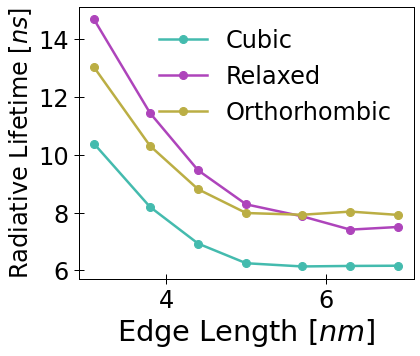

In [20]:
colors = ['#44BBAE', '#AE44BB', '#BBAE44']

# plt.tight_layout()

## Plot the radiative lifetime trends with size at room temperature

os.chdir(base_dir + 'CsPbI3')

fig, ax = plt.subplots()
fig.set_size_inches(6,5)
fig.patch.set_facecolor('w')
plt.rcParams.update({'font.size': 24})
# Configure the axes to plot energy level diagrams
ax.tick_params(top=False, bottom=True, left=True, right=False)
ax.tick_params(axis='both',which='major', direction='inout',length=10,width=1.0,color='black',pad=5,labelsize=font_sz,labelcolor='black',labelrotation=0)
ax.spines['top'].set_visible(True); ax.spines['right'].set_visible(True); #ax[i].spines['bottom'].set_visible(False)
if mat_dir == 'CsPbI3': ax.set_xlabel(r'Edge Length $[nm]$', fontsize='large')
else: ax.set_xlabel(r'Diameter $[nm]$', fontsize='large')
ax.set_ylabel(r'Radiative Lifetime $[ns]$', fontsize=font_sz)

edge_lens = np.array(size_dict[mat_dir], dtype=np.float64)

for i, shape in enumerate(shape_dict[mat_dir]):
    ax.plot(edge_lens[1:], lifetimes[300][mat_dir][shape]['xton'][1:], markersize=8, linewidth=2.5, marker='o', color=colors[i], label=shape)

ax.legend(frameon=False, fontsize=font_sz)
plt.savefig(f"{mat_dir}_xton_lifetimes_300K.pdf", format='pdf', dpi=800, bbox_inches = 'tight', pad_inches = 0.1)

plt.show()

os.chdir(base_dir)

# Non-interacting e-h radiative lifetimes

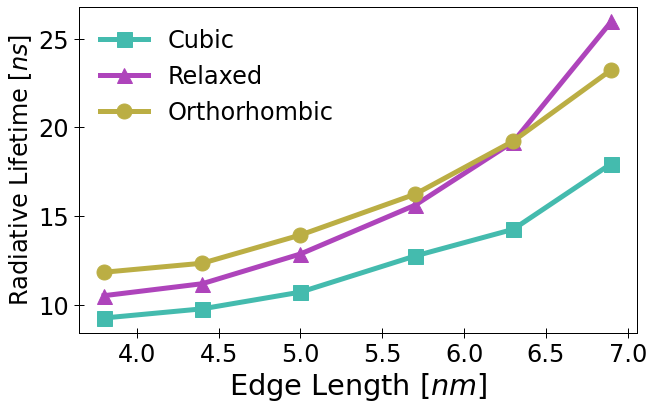

In [21]:
colors = ['#44BBAE', '#AE44BB', '#BBAE44']
markers = ['s', '^', 'o']
## Plot the radiative lifetime trends with size at room temperature
for mat_dir in material_dirs:
    os.chdir(base_dir + mat_dir)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10,6)
    fig.patch.set_facecolor('w')
    plt.rcParams.update({'font.size': 24})
    # Configure the axes to plot energy level diagrams
    ax.tick_params(top=False, bottom=True, left=True, right=False)
    ax.tick_params(axis='both',which='major', direction='inout',length=10,width=1.0,color='black',pad=5,labelsize=font_sz,labelcolor='black',labelrotation=0)
    ax.spines['top'].set_visible(True); ax.spines['right'].set_visible(True); #ax[i].spines['bottom'].set_visible(False)
    if mat_dir == 'CsPbI3': ax.set_xlabel(r'Edge Length $[nm]$', fontsize='large')
    else: ax.set_xlabel(r'Diameter $[nm]$', fontsize='large')
    ax.set_ylabel(r'Radiative Lifetime $[ns]$', fontsize=font_sz)

    edge_lens = np.array(size_dict[mat_dir], dtype=np.float64)
    
    for i, shape in enumerate(shape_dict[mat_dir]):
        ax.plot(edge_lens[2:], lifetimes[300][mat_dir][shape]['qp'][2:], markersize=15, linewidth=5.0, marker=markers[i], color=colors[i], label=shape)
        output = np.concatenate((edge_lens[2:].reshape(-1,1), lifetimes[300][mat_dir][shape]['qp'][2:].reshape(-1,1) ), axis = 1)
        np.savetxt(f"CsPbI3_lifetimes_uncorrelated_{shape}_{temp}K.dat", output, fmt='%.2f %.4f', header='size(nm) <tau>(ns)')

    
    ax.legend(frameon=False, fontsize=font_sz)
    plt.savefig(f"{mat_dir}_qp_lifetimes_300K.png", format='png', dpi=800, bbox_inches = 'tight', pad_inches = 0.1)
    
    plt.show()

os.chdir(base_dir)

# Boltzmann factors

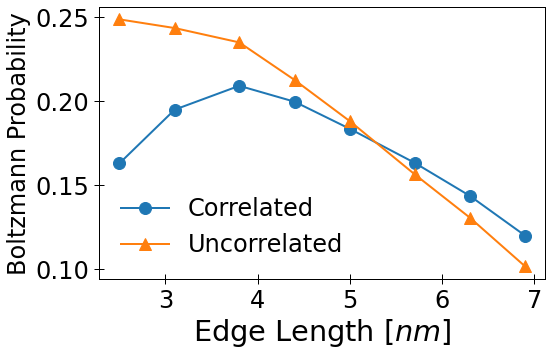

In [22]:
## Plot the radiative lifetime trends with size at room temperature

os.chdir(base_dir + mat_dir)
edge_lens = np.array(size_dict['CsPbI3'], dtype=np.float64)

shape = 'Orthorhombic'
n_xton = 6
temp = 300
kBT_eV = kB * temp * 27.211

boltz_prob_sz = []
boltz_prob_sz_qp = []

# Get data from stored dictionaries
ene_xton = ene_dict[300]['CsPbI3'][shape]['xton']
ene_qp = ene_dict[300]['CsPbI3'][shape]['qp']
# print(ene_xton)
for i in range(len(edge_lens)):
    E_n = ene_xton[i]
    E_ia = ene_qp[i]
    #print(f"Energies for size {i} = {E_n}")
    boltz_factors = np.exp(- ((E_n - E_n[0])*27.211) / kBT_eV)
    Q = np.sum(boltz_factors)
    boltz_prob = boltz_factors / Q
    #print(f"Boltz probs for size {i} = {boltz_prob}")
    boltz_qp = np.exp(- ((E_ia - E_ia[0])*27.211) / kBT_eV)
    Q = np.sum(boltz_qp)
    boltz_prob_qp = boltz_qp / Q
    
    boltz_prob_sz.append(boltz_prob)
    boltz_prob_sz_qp.append(boltz_prob_qp)


boltz_prob_sz = np.array(boltz_prob_sz)
boltz_prob_sz_qp = np.array(boltz_prob_sz_qp)

##################################################
##################################################
######### PLOT
##################################################
##################################################

fig, ax = plt.subplots()
fig.set_size_inches(8,5)
fig.patch.set_facecolor('w')
plt.rcParams.update({'font.size': 24})

# Configure the axes to plot energy level diagrams
ax.tick_params(top=False, bottom=True, left=True, right=False)
ax.tick_params(axis='both',which='major', direction='inout',length=10,width=1.0,color='black',pad=5,labelsize=font_sz,labelcolor='black',labelrotation=0)
ax.spines['top'].set_visible(True); ax.spines['right'].set_visible(True); #ax[i].spines['bottom'].set_visible(False)
ax.set_xlabel(r'Edge Length $[nm]$', fontsize='large')
ax.set_ylabel(r'Boltzmann Probability', fontsize=font_sz)

ax.plot(edge_lens, boltz_prob_sz[:,1], markersize=12, linewidth=2.0, marker='o', label=f"Correlated")
ax.plot(edge_lens, boltz_prob_sz_qp[:,1], markersize=12, linewidth=2.0, marker='^', label=f"Uncorrelated")

#ax.set_xlim(2.3, 5.5)
ax.legend(frameon=False, fontsize=font_sz)
plt.savefig(f"CsPbI3_boltz_factors_{shape}_{temp}K.pdf", format='pdf', dpi=400, bbox_inches = 'tight', pad_inches = 0.1)

# Print output for analysis
fmt_str = ["%.3f " for i in range(1)]
head = ["sz   "] + [f"p_{i}   " for i in range(1)]
headr = " ".join(head)

output = np.concatenate((edge_lens.reshape(-1,1), boltz_prob_sz[:,1].reshape(-1,1) ), axis = 1)
np.savetxt(f"CsPbI3_correlated_xton_boltz_{shape}_{temp}K.dat", output, fmt = ["% .3f "]+fmt_str, header = headr)

output = np.concatenate((edge_lens.reshape(-1,1), boltz_prob_sz_qp[:,1].reshape(-1,1) ), axis = 1)
np.savetxt(f"CsPbI3_uncorrelated_xton_boltz_{shape}_{temp}K.dat", output, fmt = ["% .3f "]+fmt_str, header = headr)


plt.show()


os.chdir(base_dir)

# EXCITON STATE FITS AND EXTRAPOLATION

In [23]:
from scipy.optimize import curve_fit

In [24]:
def lin_model(x, a, b):
    return a*x + b

def ene_model(x, a, b, c, d):
    return a*np.power(x - b, c) + d


def boltz_model(x, a, b, c):
    return -a * (x-b)**2 + c

## Exciton states from BSE

In [26]:
## Read in the energies and oscillator strengths for the lowest exciton states
save_dir = base_dir + 'CsPbI3/'
os.chdir('/Users/dchabeda/Desktop/Rabani/project/rad_lifetime/publication/data/rad_lifetime/CsPbI3')

# Lever to toggle the shape
shape = 'Relaxed'

if shape == 'Cubic':
    shape_col = '#44BBAE'
if shape == 'Orthorhombic':
    shape_col = '#BBAE44'
if shape == 'Relaxed':
    shape_col = '#AE44BB'


all_tau = lifetimes[300][mat_dir][shape]['xton']

n_pt_rm = -2

# Get data on E_n and oscillator strengths from dictionaries
ene_xton = ene_dict[300]['CsPbI3'][shape]['xton']
mu2_xton = mu2_dict[300]['CsPbI3'][shape]['xton']

all_edge_lens = np.array(size_dict['CsPbI3'], dtype=np.float64)

E_n = []
for i, ene in enumerate(ene_xton):
    E_n.append(ene)

E_n = np.array(E_n)[:n_pt_rm]
mu2 = np.array(mu2_xton)[:n_pt_rm]
edge_lens = all_edge_lens[:n_pt_rm]

# mask = [True, True, True, True, False, True]
# E_n = E_n[mask]
# mu2 = mu2[mask]
# edge_lens = edge_lens[mask]
# E_n = np.delete(E_n, 4, axis = 0)
# mu2 = np.delete(mu2, 4, axis = 0)
# edge_lens = np.delete(edge_lens, 4)

n_xton = 1024

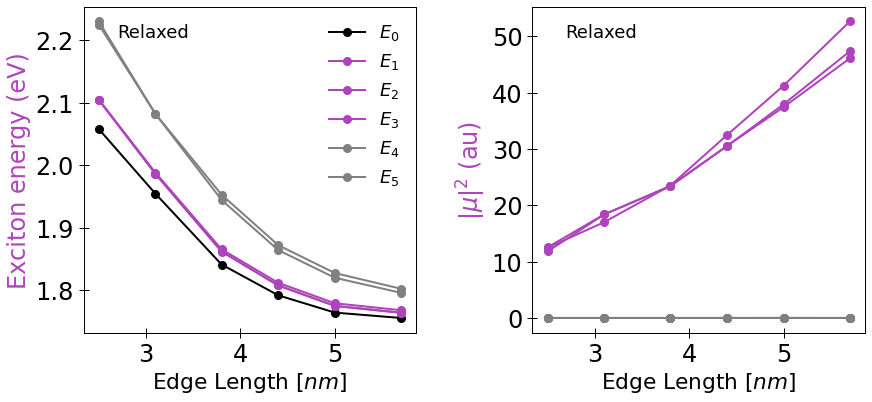

In [27]:
colors = ['k', shape_col, shape_col, shape_col, 'gray', 'gray', 'gray']

NC_sz = edge_lens
# For aesthetically clean code, read in the current values from dicts
n_xton_prnt = 6

# Plot the lowest energy exciton energies as a function of size
# + avg. oscillator strength of the bright states

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 6)
fig.patch.set_facecolor('w')
plt.rcParams.update({'font.size': 18})

# Configure the axes to plot energy level diagrams
for i in range(len(ax)):
    ax[i].tick_params(top=False, bottom=True, left=True, right=False)

    ax[i].tick_params(
        axis='both', which='major', direction='inout', length=10, width=1.0,
        color='black', pad=5, labelsize=font_sz, labelcolor='black', labelrotation=0
    )

    ax[i].spines['top'].set_visible(True); 
    ax[i].spines['right'].set_visible(True);
    ax[i].set_xlabel(r'Edge Length $[nm]$', fontsize='large')


# Plot the lowest n_xton excitons as a two level system
for i in range(n_xton_prnt):
    if i < 5:
        color = colors[i]
    else:
        color = 'gray'
        
    ax[0].plot(NC_sz, E_n[:, i] * 27.211, markersize=8, linewidth=2.0, marker='o', color=color, label=f"$E_{i}$")
    ax[1].plot(NC_sz, mu2[:, i], markersize=8, linewidth=2.0, marker='o', color=color, label=f"$|\mu_{i}|^2$")
    ax[0].set_ylabel(r'Exciton energy (eV)', color=colors[1], fontsize=font_sz)
    ax[1].set_ylabel(r'$|\mu|^2$ (au)', color=colors[1], fontsize=font_sz)


# Configure axis labels and printing

ax[0].legend(frameon=False, fontsize=18, loc = "best")
#ax[1].legend(frameon=False, fontsize=18, loc='best')
ax[0].text(0.1, 0.95, shape, transform=ax[0].transAxes,
        verticalalignment='top', horizontalalignment='left')
ax[1].text(0.1, 0.95, shape, transform=ax[1].transAxes,
        verticalalignment='top', horizontalalignment='left')

plt.subplots_adjust(wspace=0.35)

plt.savefig(f"{save_dir}CsPbI3_ene_mu2_{shape}.pdf", format='pdf', dpi=300, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

# Print output
output = np.concatenate((NC_sz.reshape(-1,1), (E_n[:,:n_xton]*27.211) ), axis=1)
np.savetxt(f"{save_dir}CsPbI3_xton_E_{shape}_{temp}K_n{n_xton}.dat", output.T, fmt="%-3.5f")

output = np.concatenate((NC_sz.reshape(-1,1), mu2[:,:n_xton]), axis=1)
np.savetxt(f"{save_dir}/CsPbI3_xton_mu2_{shape}_{temp}K_n{n_xton}.dat", output.T, fmt="%-3.5f")

os.chdir(base_dir)


## Fit exciton states to polynomial

In [28]:
# Fit the exciton data from BSE to size-dependent curves
x_range = np.linspace(2.3, 12, 80)
p0init = [0.05, -0.12, -1.4, 0.06]

def fit_ene_mu_xton(x_range, edge_lens, E_n, mu2, n_xton, p0=p0init):
    # Fit models to the stored data
    mu2_pars = []
    ene_pars = []
    mu2_x = []
    ene_x = []
    
    bounds = ([0, -0.25, -1.4, 0.0], [0.1, 0.15, -1.2, 0.1])
    bounds_mu = ([0.0, -1e10], [1e10, 1e10])
    # Produce fits and extrapolate the values as a function of size
    for i in range(n_xton):
        popt_mu2  = curve_fit(lin_model, edge_lens, mu2[:, i], bounds=bounds_mu)[0]
        popt_ene = curve_fit(ene_model, edge_lens, E_n[:, i], p0=p0init, bounds=bounds)[0]
        
        mu2_pars.append(popt_mu2)
        ene_pars.append(popt_ene)
        # Extrapolate values based on our models
        mu2_x.append( lin_model(x_range, *popt_mu2) )
        ene_x.append( ene_model(x_range, *popt_ene) )

    mu2_pars = np.array(mu2_pars)
    ene_pars = np.array(ene_pars)
    mu2_x = np.array(mu2_x)
    ene_x = np.array(ene_x)
    
    return ene_x, mu2_x


ene_x, mu2_x = fit_ene_mu_xton(x_range, edge_lens, E_n, mu2, n_xton)
# Print fit parameters

# for i in range(n_xton):
#     #print(f"Parameters for xton mu2 {i} fit: {mu2_pars[i]} ({mu2_pars[i]})\n")
#     print(f"Parameters for xton ene {i} fit: {ene_pars[i]} ({ene_pars[i] * 27.211})\n")


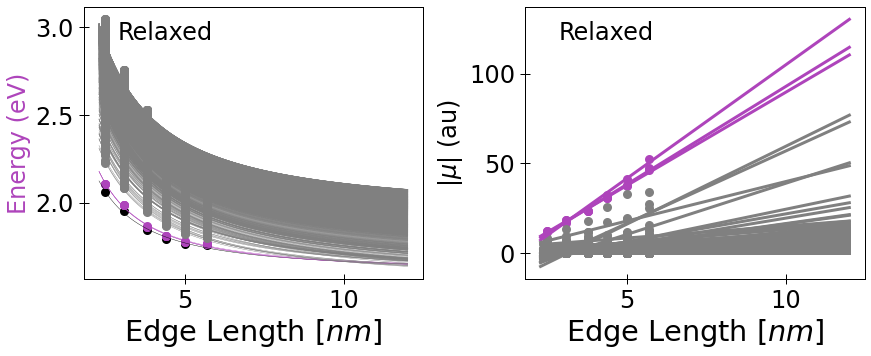

In [29]:
colors = ['k', shape_col, shape_col, shape_col, 'gray', 'gray', 'gray']

n_xton_prnt = n_xton
# Initialize figure and axis
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('w')
plt.rcParams.update({'font.size': 24})

# Configure axes for energy level diagrams
for i in range(len(ax)):
    ax[i].tick_params(top=False, bottom=True, left=True, right=False)
    ax[i].tick_params(axis='both', which='major', direction='inout', length=10, width=1.0, 
                   color='black', pad=5, labelsize=font_sz, labelcolor='black', labelrotation=0)
    ax[i].spines['top'].set_visible(True)
    ax[i].spines['right'].set_visible(True)
    ax[i].set_xlabel(r'Edge Length $[nm]$', fontsize='large')



# Plot fitted curves
for i in range(n_xton_prnt):
    if i > 5:
        color = 'gray'
    else:
        color=colors[i]
    # Energies
    ax[0].plot(x_range, ene_x[i] * 27.211, linewidth=0.4, color=color)#, label=f"E_{i}")
    ax[0].scatter(edge_lens, E_n[:, i] * 27.211, linewidth=3.0, color=color)
    
    ax[1].plot(x_range, mu2_x[i], linewidth=3.0, color=color)#, label=f"E_{i}")
    ax[1].scatter(edge_lens, mu2[:, i], linewidth=3.0, color=color)
    
    ax[0].set_ylabel(r'Energy (eV)', color=colors[1], fontsize=font_sz)
    ax[1].set_ylabel(r'$|\mu|$ (au)', color=colors[0], fontsize=font_sz)

ax[0].text(0.1, 0.95, shape, transform=ax[0].transAxes,
        verticalalignment='top', horizontalalignment='left')
ax[1].text(0.1, 0.95, shape, transform=ax[1].transAxes,
        verticalalignment='top', horizontalalignment='left')


plt.subplots_adjust(wspace=0.3)
# Show the plot
plt.savefig(f"{save_dir}CsPbI3_ene_mu2_{shape}_{n_xton}_fit.pdf", format='pdf', dpi=300, bbox_inches = 'tight', pad_inches = 0.1)

plt.show()


In [30]:
##################################################
# Calculate the rates from BSE calculations
##################################################

def rate_from_BSE(edge_lens, E_n, mu2, n_xton):
    # Calculate the rates from BSE data
    # First, calc the partition function and probabilities
    boltz_l = [] # Boltzman factors of excitons at each edge_len, l
    for l in range(len(edge_lens)):
        boltz_factors = np.exp(- ((E_n[l] - E_n[l, 0])*27.211) / kBT_eV )
        boltz_l.append(boltz_factors)

    boltz_l = np.array(boltz_l)
    Q = np.sum(boltz_l, axis = 1)
    boltz_prob_bse = boltz_l / Q[:, np.newaxis]

    # The total rate is the sum of the individual rates from each exciton
    rate_from_BSE = 0
    for i in range(n_xton):
        rate_from_BSE += (boltz_prob_bse[:, i] * (E_n[:, i]**3 * mu2[:, i]) / (prefactor * AUTOS * 1e9))

    return rate_from_BSE, boltz_prob_bse

##################################################
# Calculate the rates from the fits
##################################################

def rate_from_fit(x_range, ene_x, mu2_x, n_xton):
    # First, the Boltzmann factors
    # These are already organized by state, so no need to restructure
    ene_fit = ene_x.T
    mu2_fit = mu2_x.T
    boltz_l = [] # Boltzman factors of excitons at each edge_len, l
    for l in range(len(x_range)):
        boltz_factors = np.exp(- ((ene_fit[l] - ene_fit[l, 0])*27.211) / kBT_eV )
        boltz_l.append(boltz_factors)

    boltz_l = np.array(boltz_l)
    Q = np.sum(boltz_l, axis = 1)
    boltz_prob_fit = boltz_l / Q[:, np.newaxis]

    rate_from_fit = 0
    for i in range(n_xton):
        rate_from_fit += (boltz_prob_fit[:, i] * (ene_fit[:,i]**3 * mu2_fit[:,i]) / (prefactor * AUTOS * 1e9))
    
    return rate_from_fit, boltz_prob_fit



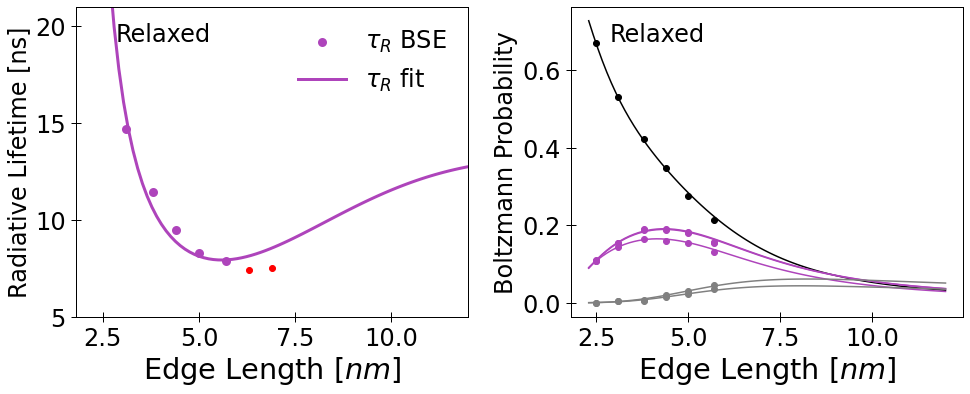

In [31]:
# Compute the BSE rates

BSE_rate, BSE_boltz = rate_from_BSE(edge_lens, E_n, mu2, n_xton)
lifetime = 1 / BSE_rate

# print output data files
output = np.concatenate((edge_lens.reshape(-1,1), lifetime.reshape(-1,1)), axis = 1)
np.savetxt(f"{save_dir}/CsPbI3_lifetime_{shape}_{temp}K_n{n_xton}_BSE.dat", output, fmt="%.4f", header="sz    <tau>_BSE")

# Compute the rates from fits of the BSE energies and osc. strengths
fit_rate, fit_boltz = rate_from_fit(x_range, ene_x, mu2_x, n_xton)
# Save this output as a file
lifetime = 1 / fit_rate

# print output data files
output = np.concatenate((x_range.reshape(-1,1), lifetime.reshape(-1,1)), axis = 1)
np.savetxt(f"{save_dir}/CsPbI3_lifetime_{shape}_{temp}K_n{n_xton}_fit.dat", output, fmt="%.4f", header="x    <tau>_fit")


##################################################
# Plot the radiative lifetimes
##################################################


fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.patch.set_facecolor('w')
plt.rcParams.update({'font.size': 24})

# Configure axes
for i in range(len(ax)):
    ax[i].tick_params(top=False, bottom=True, left=True, right=False)
    ax[i].tick_params(axis='both', which='major', direction='inout', length=10, width=1.0, 
                   color='black', pad=5, labelsize=font_sz, labelcolor='black', labelrotation=0)
    ax[i].spines['top'].set_visible(True)
    ax[i].spines['right'].set_visible(True)

    ax[i].set_xlabel(r'Edge Length $[nm]$', fontsize='large')
    
# Plot the rates

ax[0].scatter(edge_lens, 1 / BSE_rate, linewidth=3.0, color=shape_col, label=r"$\tau_R$ BSE")
ax[0].plot(x_range, 1 / fit_rate, linewidth=3.0, color=shape_col, label=r"$\tau_R$ fit")

# Plot the next-point prediction
ax[0].scatter(all_edge_lens[n_pt_rm:], all_tau[n_pt_rm:], color = 'r')

for i in range(n_xton):
    if i > 5:
        color = 'gray'
    else:
        color=colors[i]
        ax[1].scatter(edge_lens, BSE_boltz[:, i], color=color)
        ax[1].plot(x_range, fit_boltz[:, i], color=color)

ax[0].set_xlim(1.8, 12)
ax[0].set_ylim(5, 21)

# Set y labels
ax[0].set_ylabel("Radiative Lifetime [ns]")
ax[1].set_ylabel(r"Boltzmann Probability")
ax[0].text(0.1, 0.95, shape, transform=ax[0].transAxes,
        verticalalignment='top', horizontalalignment='left')
ax[1].text(0.1, 0.95, shape, transform=ax[1].transAxes,
        verticalalignment='top', horizontalalignment='left')

ax[0].legend(frameon=False, fontsize=font_sz)

plt.subplots_adjust(wspace=0.4)
plt.tight_layout()

plt.savefig(f"{save_dir}/CsPbI3_pred_lifetime_{shape}_{temp}K_n{n_xton}.pdf", dpi=400, format='pdf')

plt.show()


## Figure 5a

Cubic
Orthorhombic
Relaxed


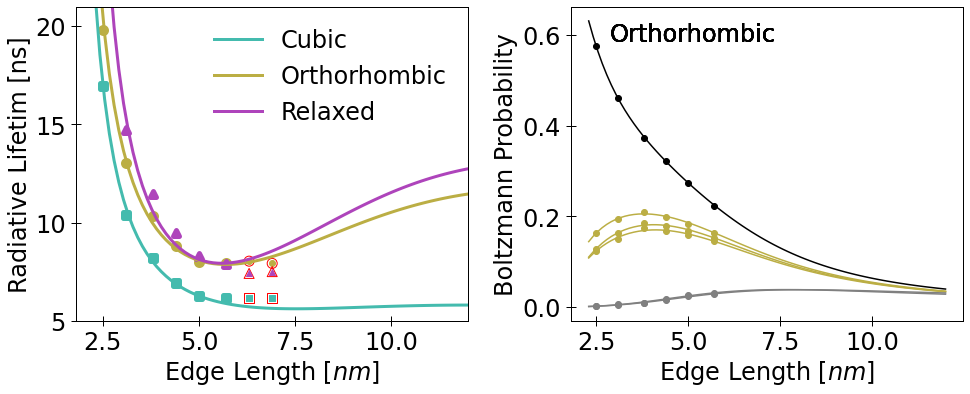

In [34]:
marker_list = ['s', 'o', '^']
shape_list = ['Cubic', 'Orthorhombic', 'Relaxed']

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.patch.set_facecolor('w')
plt.rcParams.update({'font.size': 24})

# Configure axes
for i in range(len(ax)):
    ax[i].tick_params(top=False, bottom=True, left=True, right=False)
    ax[i].tick_params(axis='both', which='major', direction='inout', length=10, width=1.0, 
                   color='black', pad=5, labelsize=font_sz, labelcolor='black', labelrotation=0)
    ax[i].spines['top'].set_visible(True)
    ax[i].spines['right'].set_visible(True)

    ax[i].set_xlabel(r'Edge Length $[nm]$', fontsize=font_sz)


for j, shape in enumerate(shape_list):
    print(shape)
    if shape == 'Cubic':
        shape_col = '#44BBAE'
    if shape == 'Orthorhombic':
        shape_col = '#BBAE44'
    if shape == 'Relaxed':
        shape_col = '#AE44BB'
        
    colors = ['k', shape_col, shape_col, shape_col, 'gray', 'gray', 'gray']

    all_tau = lifetimes[300][mat_dir][shape]['xton']

    n_pt_rm = -2

    # Get data on E_n and oscillator strengths from dictionaries
    ene_xton = ene_dict[300]['CsPbI3'][shape]['xton']
    mu2_xton = mu2_dict[300]['CsPbI3'][shape]['xton']

    all_edge_lens = np.array(size_dict['CsPbI3'], dtype=np.float64)

    E_n = []
    for i, ene in enumerate(ene_xton):
        E_n.append(ene)

    E_n = np.array(E_n)[:n_pt_rm]
    mu2 = np.array(mu2_xton)[:n_pt_rm]
    edge_lens = all_edge_lens[:n_pt_rm]
    
    # Compute the BSE rates

    BSE_rate, BSE_boltz = rate_from_BSE(edge_lens, E_n, mu2, n_xton)
    lifetime = 1 / BSE_rate

    # print output data files
    output = np.concatenate((edge_lens.reshape(-1,1), lifetime.reshape(-1,1)), axis = 1)
    np.savetxt(f"{save_dir}/CsPbI3_lifetime_{shape}_{temp}K_n{n_xton}_BSE.dat", output, fmt="%.4f", header="sz    <tau>_BSE")

    # Compute the rates from fits of the BSE energies and osc. strengths
    ene_x, mu2_x = fit_ene_mu_xton(x_range, edge_lens[mask], E_n, mu2, n_xton)
    fit_rate, fit_boltz = rate_from_fit(x_range, ene_x, mu2_x, n_xton)
    
    lifetime = 1 / fit_rate

    # print output data files
    output = np.concatenate((x_range.reshape(-1,1), lifetime.reshape(-1,1)), axis = 1)
    np.savetxt(f"{save_dir}/CsPbI3_lifetime_{shape}_{temp}K_n{n_xton}_fit.dat", output, fmt="%.4f", header="x    <tau>_fit")


    ##################################################
    # Plot the radiative lifetimes
    ##################################################
    # Plot the rates

    ax[0].scatter(edge_lens, 1 / BSE_rate, linewidth=5.0, color=shape_col, marker=marker_list[j])
    ax[0].plot(x_range, 1 / fit_rate, linewidth=3.0, color=shape_col, label=shape)

    # Plot the next-point prediction
    # Outer ring (hollow circles)
    ax[0].scatter(all_edge_lens[n_pt_rm:], all_tau[n_pt_rm:], s=100, facecolors='none', edgecolors='r', marker=marker_list[j])
    ax[0].scatter(all_edge_lens[n_pt_rm:], all_tau[n_pt_rm:], color=shape_col, marker=marker_list[j])

    if shape == 'Orthorhombic':
        for i in range(n_xton):
            if i > 5:
                color = 'gray'
            else:
                color=colors[i]
                ax[1].scatter(edge_lens, BSE_boltz[:, i], color=color)
                ax[1].plot(x_range, fit_boltz[:, i], color=color)
                ax[1].text(0.1, 0.95, shape, transform=ax[1].transAxes,
                    verticalalignment='top', horizontalalignment='left')

ax[0].set_xlim(1.8, 12)
ax[0].set_ylim(5, 21)
ax[0].set_yticks([5, 10, 15, 20])
# Set y labels
ax[0].set_ylabel(r"Radiative Lifetim [ns]")
ax[1].set_ylabel(r"Boltzmann Probability")


ax[0].legend(frameon=False, fontsize=font_sz)

plt.subplots_adjust(wspace=0.4)
plt.tight_layout()

plt.savefig(f"{save_dir}/CsPbI3_pred_lifetime_{temp}K_n{n_xton}.pdf", dpi=400, format='pdf')

plt.show()


## Dependence on number of dim states

Cubic: Non-monotonic at 140 excitons
Relaxed: Non-monotonic at 40 excitons
Orthorhombic: Non-monotonic at 40 excitons


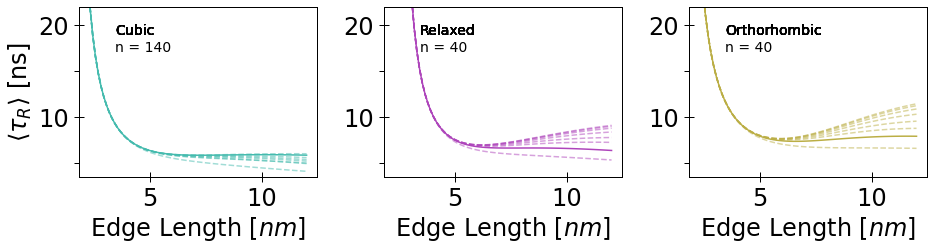

In [35]:
colors = ['#44BBAE', '#AE44BB', '#BBAE44']

n_xton_list = np.arange(20, 180, 20)
shape_list = ['Cubic', 'Relaxed', 'Orthorhombic']
n_shapes = len(shape_list)
temp_list = [300]

for temp in temp_list:
    fig, ax = plt.subplots(1, n_shapes, figsize=(4.5*n_shapes, 4))
    for i, shape in enumerate(shape_list):
        ax[i].yaxis.set_minor_locator(AutoMinorLocator(2))
        ax[i].tick_params(top=False, bottom=True, left=True, right=False)
        ax[i].tick_params(axis='both', which='major', direction='inout', length=10, width=1.0, 
                       color='black', pad=5, labelsize=font_sz, labelcolor='black', labelrotation=0)
        ax[i].tick_params(axis='both', which='minor', direction='out', length=5, width=1.0, 
                       color='black', pad=5, labelsize=font_sz, labelcolor='black', labelrotation=0)
        ax[i].spines['top'].set_visible(True)
        ax[i].spines['right'].set_visible(True)

        ax[i].set_xlabel(r'Edge Length $[nm]$', fontsize='medium')
        
        # Get data on E_n and oscillator strengths from dictionaries
        ene_xton = ene_dict[temp]['CsPbI3'][shape]['xton']
        mu2_xton = mu2_dict[temp]['CsPbI3'][shape]['xton']

        edge_lens = np.array(size_dict['CsPbI3'], dtype=np.float64)[1:]

        E_n = []
        for ene in ene_xton:
            E_n.append(ene)

        E_n = np.array(E_n)[1:]
        mu2 = np.array(mu2_xton)[1:]
        is_nm = 0
        
        for nx in n_xton_list:
#             print(f"Shape: {shape} n_xton = {nx}\n")
            ene_x, mu2_x = fit_ene_mu_xton(x_range, edge_lens, E_n, mu2, nx)
            
            fit_rate, fit_boltz = rate_from_fit(x_range, ene_x, mu2_x, nx)
            
            # Determine whether this lifetime curve is non-monotonic
            lifetime = 1 / fit_rate
            alph = 0.5
            ls = 'dashed'
            if is_nm == 0: calc_nm = 1
            else: calc_nm = 0
            
            if calc_nm:
                for j in range(lifetime.shape[0] - 1):
                    if lifetime[j+1] > lifetime[j]:
                        is_nm = 1
                    
#                 if is_nm == 0: print(f"{shape}: Monotonic at {nx} excitons")
                if is_nm == 1: 
                    print(f"{shape}: Non-monotonic at {nx} excitons")
                    alph = 1
                    ls = '-'
                    ax[i].text(0.15, 0.8, f"n = {nx}", transform=ax[i].transAxes, fontsize=14,
                verticalalignment='top', horizontalalignment='left')
            
#             ax.set_yscale('log')
            ax[i].set_ylim(3.5, 22.0)
            ax[i].plot(x_range, 1/fit_rate, linestyle=ls, color=colors[i], alpha=alph, label = f"n = {nx}")
            ax[i].text(0.15, 0.9, shape, transform=ax[i].transAxes, fontsize=14,
                verticalalignment='top', horizontalalignment='left')
            
            
#         ax.legend(fontsize=12, frameon=False)
    ax[0].set_ylabel(r"$\langle \tau_R \rangle$ [ns]")
    plt.tight_layout()
    plt.savefig(f"{save_dir}/CsPbI3_n_xton_turnover_{temp}K.png", dpi=400)
            

## Smallest number of params to fit behavior

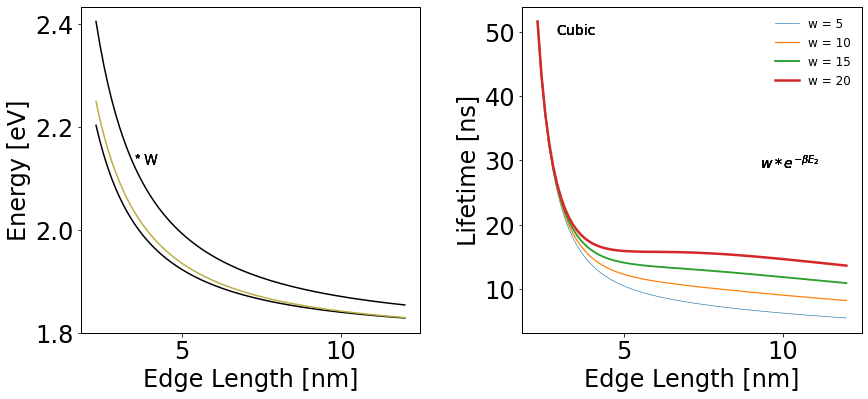

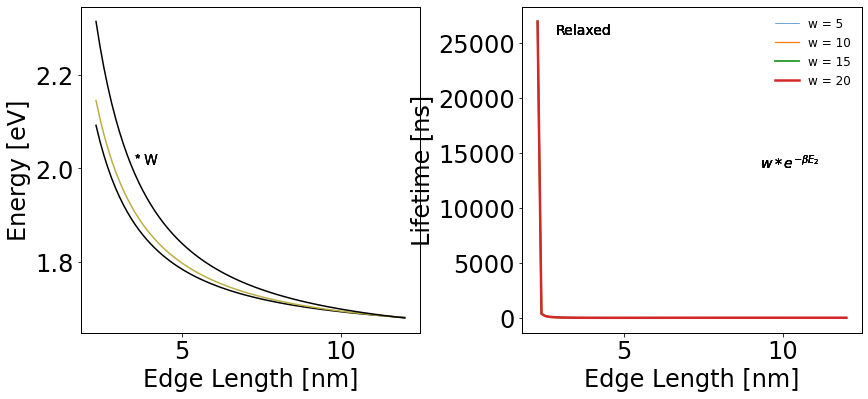

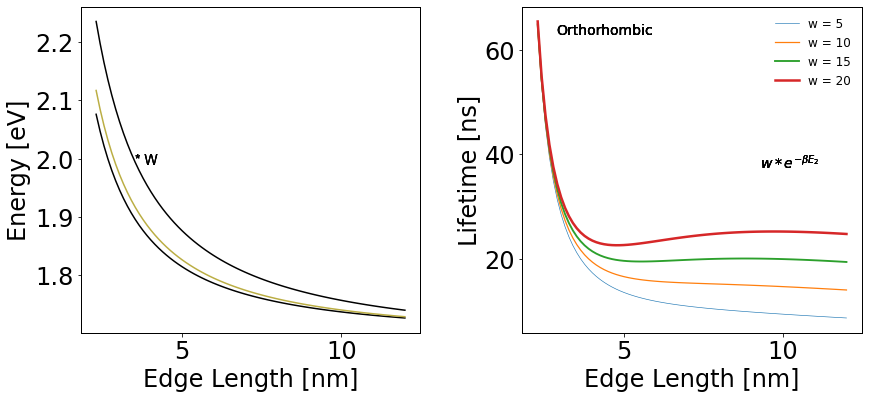

In [30]:
nx5 = 5

colors = ['k', '#BBAE44', 'k']
boltz_wt_list = np.arange(5, 25, 5)
shape_list = ['Cubic', 'Relaxed', 'Orthorhombic']
temp_list = [300]

for temp in temp_list:
    for i, shape in enumerate(shape_list):
        fig, ax = plt.subplots(1, 2, figsize=(14,6))
        # Get data on E_n and oscillator strengths from dictionaries
        ene_xton = ene_dict[temp]['CsPbI3'][shape]['xton']
        mu2_xton = mu2_dict[temp]['CsPbI3'][shape]['xton']

        edge_lens = np.array(size_dict['CsPbI3'], dtype=np.float64)[1:]

        E_n = []
        for ene in ene_xton:
            E_n.append(ene)

        E_n = np.array(E_n)[1:]
        mu2 = np.array(mu2_xton)[1:]
        
        ene_x, mu2_x = fit_ene_mu_xton(x_range, edge_lens, E_n, mu2, nx5)
        
        # Construct a three level system out of these 5 levels by averaging
        # the three bright triplets
        ene_trip = np.mean(ene_x[1:4], axis = 0)
        mu2_trip = np.mean(mu2_x[1:4], axis = 0)
        
        ene_3ls = np.concatenate((ene_x[0, :], ene_trip, ene_x[-1, :])).reshape(3,-1)
        mu2_3ls = np.concatenate((mu2_x[0, :], mu2_trip, mu2_x[-1, :])).reshape(3,-1)
        
        for j in range(3):
            ax[0].plot(x_range, 27.211*ene_3ls[j], color=colors[j])
            ax[0].text(0.16, 0.55, r"* W", transform=ax[0].transAxes, fontsize=14,
                verticalalignment='top', horizontalalignment='left', fontfamily='Arial')
        
        for wt in boltz_wt_list:
#             print(f"Shape: {shape} n_xton = {nx}\n")
            
            # First, the Boltzmann factors
            ene_fit = ene_3ls.T
            mu2_fit = mu2_3ls.T
            boltz_l = [] # Boltzman factors of excitons at each edge_len, l
            for l in range(len(x_range)):
                boltz_factors = np.exp(- ((ene_fit[l] - ene_fit[l, 0])*27.211) / kBT_eV )
                boltz_l.append(boltz_factors)

            boltz_l = np.array(boltz_l)
            # Increase the weight of the last term
            boltz_l[:, -1] *= wt
            #print(boltz_l)
            Q = np.sum(boltz_l, axis = 1)
            boltz_prob_fit = boltz_l / Q[:, np.newaxis]

            fit_rate = 0
            for i in range(3):
                fit_rate += (boltz_prob_fit[:, i] * (ene_fit[:,i]**3 * mu2_fit[:,i]) / (prefactor * AUTOS * 1e9))

            
            #ax.set_yscale('log')
            ax[1].plot(x_range, 1/fit_rate, linewidth=wt/8, label = f"w = {wt}")
            ax[1].text(0.7, 0.55, r"$w*e^{-\beta E_2}$", transform=ax[1].transAxes, fontsize=14,
                verticalalignment='top', horizontalalignment='left', fontfamily='Arial')
            ax[1].text(0.1, 0.95, shape, transform=ax[1].transAxes, fontsize=14,
                verticalalignment='top', horizontalalignment='left')
            
        ax[1].legend(fontsize=12, frameon=False)
        ax[0].set_ylabel("Energy [eV]")
        ax[0].set_xlabel("Edge Length [nm]")
        ax[1].set_ylabel("Lifetime [ns]")
        ax[1].set_xlabel("Edge Length [nm]")
        plt.subplots_adjust(wspace=0.3)
            

# Temperature dependence of lifetimes

k = 0 idx1 = 0 idx2 = 0
Cubic
Relaxed
Orthorhombic
k = 1 idx1 = 0 idx2 = 1
Cubic
Relaxed
Orthorhombic
k = 2 idx1 = 1 idx2 = 0
Cubic
Relaxed
Orthorhombic
k = 3 idx1 = 1 idx2 = 1
Cubic
Relaxed
Orthorhombic


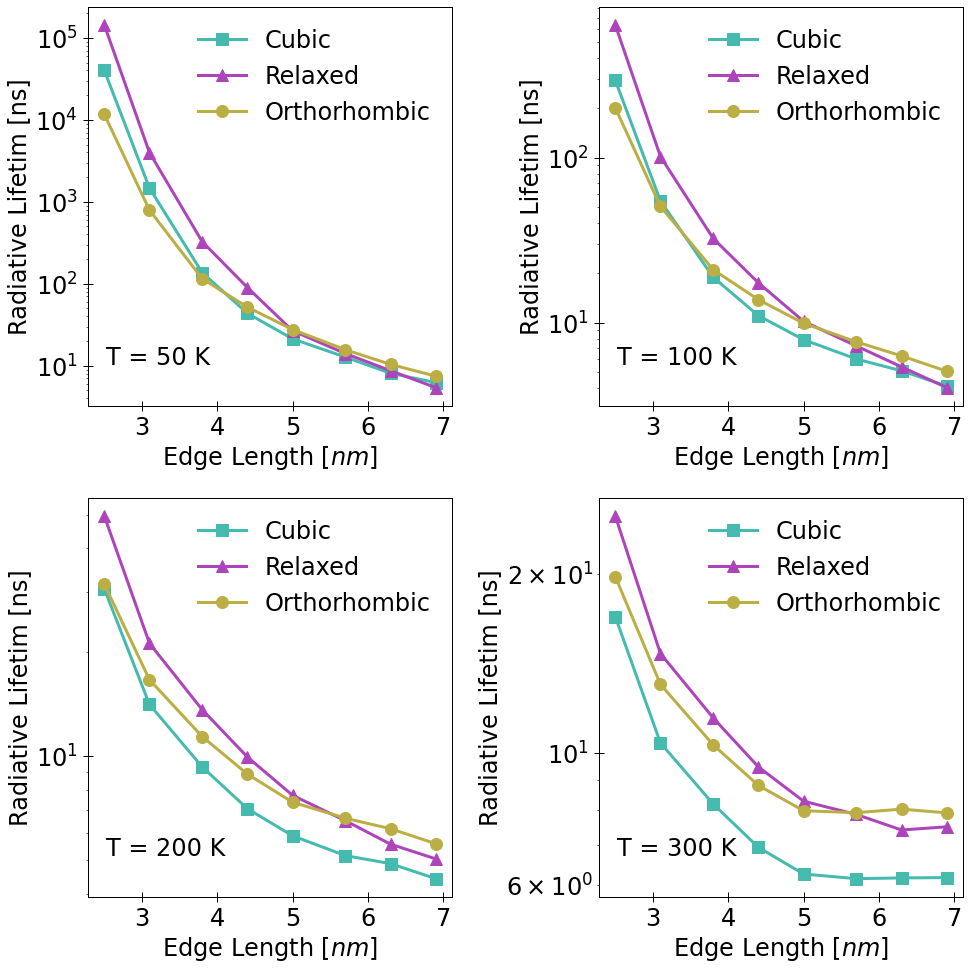

In [31]:
temp_list = [50, 100, 200, 300]
n_xton = 2000

fig, ax = plt.subplots(2, 2, figsize=(14, 14))
fig.patch.set_facecolor('w')
plt.rcParams.update({'font.size': 24})

# Configure axes
for i in range(2):
    for j in range(2):
        ax[i][j].tick_params(top=False, bottom=True, left=True, right=False)
        ax[i][j].tick_params(axis='both', which='major', direction='inout', length=10, width=1.0, 
                       color='black', pad=5, labelsize=font_sz, labelcolor='black', labelrotation=0)
        ax[i][j].spines['top'].set_visible(True)
        ax[i][j].spines['right'].set_visible(True)

        ax[i][j].set_xlabel(r'Edge Length $[nm]$', fontsize=font_sz)



for k, temp in enumerate(temp_list):
    idx1 = k // 2
    idx2 = k % 2
    print(f"k = {k} idx1 = {idx1} idx2 = {idx2}")
    
    kBT = kB * temp
    kBT_eV = kBT * 27.211
    ## Plot the radiative lifetime trends with size at room temperature
    marker_list = ['s', '^', 'o']


    for j, shape in enumerate(shape_list):
        print(shape)
        if shape == 'Cubic':
            shape_col = '#44BBAE'
        if shape == 'Orthorhombic':
            shape_col = '#BBAE44'
        if shape == 'Relaxed':
            shape_col = '#AE44BB'

        colors = ['k', shape_col, shape_col, shape_col, 'gray', 'gray', 'gray']

        all_tau = lifetimes[300][mat_dir][shape]['xton']

        n_pt_rm = None

        # Get data on E_n and oscillator strengths from dictionaries
        ene_xton = ene_dict[300]['CsPbI3'][shape]['xton']
        mu2_xton = mu2_dict[300]['CsPbI3'][shape]['xton']

        all_edge_lens = np.array(size_dict['CsPbI3'], dtype=np.float64)

        E_n = []
        for i, ene in enumerate(ene_xton):
            E_n.append(ene)

        E_n = np.array(E_n)[:n_pt_rm]
        mu2 = np.array(mu2_xton)[:n_pt_rm]
        edge_lens = all_edge_lens[:n_pt_rm]

        # Compute the BSE rates

        BSE_rate, BSE_boltz = rate_from_BSE(edge_lens, E_n, mu2, n_xton)
        lifetime = 1 / BSE_rate

        # print output data files
        output = np.concatenate((edge_lens.reshape(-1,1), lifetime.reshape(-1,1)), axis = 1)
        np.savetxt(f"{save_dir}/CsPbI3_lifetime_{shape}_{temp}K_n{n_xton}_BSE.dat", output, fmt="%.4f", header="sz    <tau>_BSE")


        ##################################################
        # Plot the radiative lifetimes
        ##################################################
        
        ax[idx1][idx2].plot(edge_lens, 1 / BSE_rate, linewidth=3.0, color=shape_col, marker=marker_list[j], markersize=12, label=shape)

    # Set y labels
    ax[idx1][idx2].set_yscale('log') 
    ax[idx1][idx2].set_ylabel(r"Radiative Lifetim [ns]")
    
    ax[idx1][idx2].text(0.05, 0.15, f"T = {temp} K", transform=ax[idx1][idx2].transAxes,
            verticalalignment='top', horizontalalignment='left')
    
    ax[idx1][idx2].legend(frameon=False, fontsize=font_sz)

plt.subplots_adjust(wspace=0.4)
plt.tight_layout()

plt.savefig(f"{save_dir}/CsPbI3_pred_lifetime_temp_n{n_xton}.png", dpi=600)

plt.show()


os.chdir(base_dir)

In [32]:
# t_dep_cubic = []
# t_dep_ortho = []
# t_dep_relax = []
# temps = temp_list
# for temp in temps:
#     t_dep_cubic.append(np.loadtxt(f"{base_dir}/CsPbI3/CsPbI3_lifetimes_Cubic_{temp}K.dat"))
#     t_dep_ortho.append(np.loadtxt(f"{base_dir}/CsPbI3/CsPbI3_lifetimes_Orthorhombic_{temp}K.dat"))
#     t_dep_relax.append(np.loadtxt(f"{base_dir}/CsPbI3/CsPbI3_lifetimes_Relaxed_{temp}K.dat"))
    


# t_dep_cubic = np.array(t_dep_cubic)
# t_dep_ortho = np.array(t_dep_ortho)
# t_dep_relax = np.array(t_dep_relax)


# fig, ax = plt.subplots(1,2, figsize = (10,5))

# sz_idx = 3 # 3.1 nm
# ax[0].plot(temps, t_dep_cubic[:,sz_idx,2], markersize = 8, marker='o',  label=f"{t_dep_cubic[1,sz_idx, 0]} nm cubic" )
# ax[0].plot(temps, t_dep_ortho[:,sz_idx,2], markersize = 8, marker='o',  label=f"{t_dep_ortho[1,sz_idx, 0]} nm ortho" )
# ax[0].plot(temps, t_dep_relax[:,sz_idx,2], markersize = 8, marker='o',  label=f"{t_dep_relax[1,sz_idx, 0]} nm relax" )

# sz_idx = 7 # 6.3 nm
# #ax[1].plot(temps, t_dep_cubic[:,sz_idx,2], markersize = 8, marker='o', label=f"{t_dep_cubic[1,sz_idx, 0]} nm cubic")
# #ax[1].plot(temps[:-2], t_dep_ortho[:-2,sz_idx,2], markersize = 8, marker='o',  label=f"{t_dep_ortho[1,sz_idx, 0]} nm ortho")
# ax[1].plot(temps[:-2], t_dep_relax[:-2,sz_idx,2], markersize = 8, marker='o',  label=f"{t_dep_relax[1,sz_idx, 0]} nm relax")

# ax[0].legend(frameon=False, fontsize=16)
# ax[1].legend(frameon=False, fontsize=16)

# ax[0].set_title('Small NC')
# ax[1].set_title('Medium NC')

# ax[0].set_yscale('log')
# #ax[1].set_yscale('log')

# ax[0].set_xlabel("Temperature (K)")
# ax[1].set_xlabel("Temperature (K)")
# ax[0].set_ylabel(r"$\tau_R$ (ns)")
# #ax[1].set_ylabel(r"$\tau_R$ (ns)")

# plt.savefig(f"{base_dir}/CsPbI3/lifetime_temp_dep.png", format='png', dpi=400, bbox_inches = 'tight', pad_inches = 0.1)

# plt.show()